<a href="https://colab.research.google.com/github/rvanasa/deep-antibody/blob/master/antibody_contact_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Workspace setup

!pip install -q biopython pdb-tools
!wget -nc ftp://ftp.cmbi.ru.nl/pub/software/dssp/dssp-2.0.4-linux-amd64 -O /usr/local/bin/dssp && chmod +x /usr/local/bin/dssp

from IPython.display import clear_output, display
clear_output()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import Bio
import Bio.PDB
from Bio.PDB import DSSP

contact_buffer = 4
contact_window_size = contact_buffer * 2 + 1

amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLU', 'GLN', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', '???']
oneletters = 'ARNDCEQGHILKMFPSTWYV'
ssletters = 'HBEGITS'
cdr_regions = [btype + bnum for btype in 'HL' for bnum in '123']

parser = Bio.PDB.PDBParser(get_header=True)

def parse(ident):
  if '.' not in ident:
    filename = f'{ident}.pdb'
    !wget -nc https://files.rcsb.org/download/{ident}.pdb
  else:
    filename = ident
  return parser.get_structure(ident, filename)


def run_dssp(filename):
  structure = parse(filename)
  adfs = []
  for model in structure.get_models():
    chain_info = []
    for chain in model.get_chains():
      chain_info += [(chain.id, i - 1, create_seq([r.resname])) for i, r in enumerate(chain)]
    
    dssp = DSSP(structure[0], filename)
    rows = [(c, i, rc.strip() or '-', *v) for (c, (_, i, rc)), v in dssp.property_dict.items()]

    dfs = pd.DataFrame(rows, columns=[
        'Key', 'Num', 'Sub',
        'DSSP Index', 'Residue',
        'SS', 'ASA', 'Phi', 'Psi',
        'NH->O_1_relidx', 'NH->O_1_energy',
        'O->NH_1_relidx', 'O->NH_1_energy',
        'NH->O_2_relidx', 'NH->O_2_energy',
        'O->NH_2_relidx', 'O->NH_2_energy'])
    
    dfs.insert(0, 'Model', model.id)
    adfs.append(dfs)
  
  return pd.concat(adfs)


def create_seq(rs):
  return ''.join(oneletters[amino_acids.index(r)] if r in amino_acids else 'X' for r in rs)


def cmd(command):
  if not isinstance(command, str):
    for c in command:
      cmd(c)
  if os.system(command):
    raise Exception(f'Non-zero exit code in command: $ {command}')

In [0]:
#@title Feature encoding

def encode_onehot(x, y, size=None, lenient=False):
  encoded = np.zeros((size or len(x), len(y)), dtype=np.float32)
  a = np.array([y.index(k) if k in y or not lenient else False for k in x])
  if a.dtype != np.bool:
    encoded[np.arange(len(x)), a] = 1
  return encoded


def encode_onehot_all(xs, y):
  return np.array([encode_onehot(x, y) for x in xs]).reshape(len(xs), -1)


def encode_features(df, verbose=True):
  cdrs = encode_onehot(df.Type + df.CDR.astype(str), [f'{t}{c}' for t in 'HL' for c in '123'],
                       lenient=True)###
  # cdrs = (encode_onehot(df.Type, 'LH')[:, :, None] * encode_onehot(df.CDR, (1, 2, 3))[:, None, :]).reshape(len(df), -1)
  if verbose: print(cdrs.shape)

  bwindows = encode_onehot_all(df.BWindow, oneletters)
  awindows = encode_onehot_all(df.AWindow, oneletters)
  if verbose: print(bwindows.shape, awindows.shape)
  assert bwindows.shape == awindows.shape

  ss_onehot = ssletters + '-'
  
  bsecs = encode_onehot_all(df.BSec.str.split('|'), ss_onehot)
  asecs = encode_onehot_all(df.ASec.str.split('|'), ss_onehot)
  if verbose: print(bsecs.shape, asecs.shape)
  assert bsecs.shape == asecs.shape

  bsols = np.array(list(df.BSol.str.split('|').map(lambda a: [float(f) for f in a])))
  asols = np.array(list(df.ASol.str.split('|').map(lambda a: [float(f) for f in a])))
  if verbose: print(bsols.shape, asols.shape)
  assert bsols.shape == asols.shape
  
  positions = (df.BIndex - df.CDR_S) / (df.CDR_EI - df.CDR_S)

  return np.concatenate([
      cdrs.T,
      bwindows.T,
      bsecs.T,
      bsols.T,
      awindows.T,
      asecs.T,
      asols.T,
      [positions],
      [1 - positions],
  ]).astype(np.float32).T


def generate_batch(df, multiple=2):
  # r_wkeys = ['BWindow', 'AWindow']
  # r_skeys = ['BSec', 'BSol', 'ASec', 'ASol']
  # df_reverse = df.copy()
  # df_reverse[r_wkeys] = df[r_wkeys].applymap(lambda w: w[::-1])
  # df_reverse[r_skeys] = df[r_skeys].applymap(lambda s: '|'.join(s.split('|')[::-1]))
  # df_reverse.BIndex = df_reverse.CDR_S + df_reverse.CDR_EI - df_reverse.BIndex - 1

  df_false = pd.concat([df] * multiple)
  df_false['Label'] = 0

  resample_cols = ['AKey', 'AIndex', 'AWindow', 'ASec', 'ASol']
  df_false[resample_cols] = df_false[resample_cols].sample(frac=1).values

  dfx = pd.concat([df, df_false])
  dfx = dfx.drop_duplicates(set(dfx) - {'Label'})
  dfx = dfx.sample(len(dfx))

  X = encode_features(dfx)
  y = encode_onehot(dfx.Label, list(range(2)))
  return X, y


In [0]:
#@title Decoy features

!wget -nc https://raw.githubusercontent.com/rvanasa/deep-antibody/master/feature_assembly.zip
!unzip -nq feature_assembly.zip

df_windows_cdr = pd.read_csv('windows_cdr.csv')
df_windows_all = pd.read_csv('windows_ag.csv')

clear_output()

def assemble_features(n_samples, b_inputs=None, a_inputs=None):
  dfb = df_windows_cdr
  if b_inputs:
    dfb = dfb[dfb.File.isin(b_inputs)]

  dfa = df_windows_all
  if a_inputs:
    dfa = dfa[dfa.File.isin(a_inputs)]

  n_samples = min(n_samples, len(dfb), len(dfa))
  
  #, replace=len(dfb) < n_samples
  dfb = dfb.sample(n_samples).drop(columns=['File', 'Model', 'BKey']).reset_index(drop=True)
  dfa = dfa.sample(n_samples).drop(columns=['File', 'Model', 'AKey']).reset_index(drop=True)

  df = pd.concat([dfb, dfa], axis=1)
  df = df.drop_duplicates()
  return df

In [0]:
#@title Contact features

df = pd.read_csv('features_contacts.csv')
df['Label'] = 1
df = df.drop_duplicates(['BWindow', 'AWindow'])
df = df.sample(len(df), random_state=0)

print(len(set(df.File)), (len(set(df.BWindow)), len(set(df.AWindow))))
# df

1402 (17957, 19713)


In [0]:
#@title Google Drive setup

from google.colab import drive
drive.mount('/gdrive')
clear_output()

In [0]:
#@title Data preparation

from sklearn.model_selection import train_test_split

def rebuild_data(df, const, decoy_multiple):
  df_decoy = assemble_features(len(df) * decoy_multiple, set(df.File), set(df.File))

  X_const, y_const = const

  X = np.concatenate([X_const, encode_features(df_decoy)])
  y = np.concatenate([y_const, np.tile([1, 0], (len(df_decoy), 1))])
  sort = np.random.choice(len(X), len(X), replace=False)
  return X[sort], y[sort]


files_train, files_test = train_test_split(list(set(df.File)), test_size=0.25, random_state=0)

df_train, df_test = df[df.File.isin(files_train)], df[df.File.isin(files_test)]

train_const = encode_features(df_train), encode_onehot(df_train.Label, list(range(2)))
test_const = encode_features(df_test), encode_onehot(df_test.Label, list(range(2)))

(71872, 6)
(71872, 180) (71872, 180)
(71872, 72) (71872, 72)
(71872, 9) (71872, 9)
(23047, 6)
(23047, 180) (23047, 180)
(23047, 72) (23047, 72)
(23047, 9) (23047, 9)


In [0]:
#@title Classifier model

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

load_saved_model = False #@param {"type":"boolean"}
saved_model_path = '/gdrive/My Drive/model.h5' #@param{"type":"string"}

model_metrics = [Precision(class_id=1), Recall(class_id=1)]

def create_model():
  model = Sequential([
      Input(shape=(530,)),
      Dropout(.5),
      Dense(10, activation='linear', activity_regularizer=l1(0.002)),
      Activation('relu'),
      Dense(6, activation='relu'),
      Dense(4, activation='relu'),
      Dropout(.5),
      Dense(2, activation='sigmoid'),
  ])
  model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=model_metrics)
  return model

if load_saved_model:
  clear_output()
  model = tf.keras.models.load_model(saved_model_path)
  print(f'Loaded from {saved_model_path}')
else:
  model = create_model()

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_10 (Dropout)         (None, 530)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                5310      
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_11 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                

**Loss**: "incorrectness" of the model

**Precision**: $\frac{\text{correct}}{\text{predicted}}$

**Recall**: $\frac{\text{correct}}{\text{actual}}$

In [0]:
#@title Progress monitoring

%reload_ext tensorboard
%tensorboard --logdir logs

In [0]:
#@title Classifier training

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
from tensorboard.plugins.pr_curve import summary as pr_summary
import seaborn as sns

!rm -rf ./logs

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
)
tensorboard_callback = TensorBoard('logs', histogram_freq=1)

data_interval = 200

current_epoch = 0

while True:
  X_train, y_train = rebuild_data(df_train, train_const, 2)
  X_test, y_test = rebuild_data(df_test, test_const, 2)

  print([train_const[0].shape[0], test_const[0].shape[0]])
  print([X_train.shape[0], X_test.shape[0]])

  model.fit(
      X_train, y_train,
      validation_data=(X_test, y_test),
      initial_epoch=current_epoch,
      epochs=current_epoch + data_interval,
      batch_size=2**13,
      callbacks=[lr_callback, tensorboard_callback],
      # callbacks=[tensorboard_callback],
  )
  current_epoch += data_interval

  model.save(saved_model_path)

  y_pred = model.predict([X_test])

  y_test_max = y_test.argmax(axis=1)
  y_pred_max = y_pred.argmax(axis=1)

  clear_output()
  # print()
  print(classification_report(y_test_max, y_pred_max, target_names=['False', 'True']))

  M = confusion_matrix(y_test_max, y_pred_max, normalize='true')

  fig = plt.figure(figsize=(4, 4))
  sns.heatmap(M, annot=True, cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('Ground Truth')
  plt.xlabel('Predicted')
  plt.show()

In [0]:
#@title Classifier validation

from sklearn.model_selection import RepeatedKFold, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=1)
kfold = RepeatedKFold(n_splits=5, n_repeats=100)

results = cross_val_score(estimator, X_test, y_test, cv=kfold, n_jobs=2)
results.mean()

In [0]:
#@title Target feature assembly

ag_pdb = '6w41' #@param {"type":"string"}
ag_key = 'C' #@param {"type":"string"}
ag_model = 0 #@param {"type":"integer"}

ag_file = ag_pdb if ag_pdb.endswith('.pdb') else f'{ag_pdb}.pdb'

n_antibodies = 6 #@param {type:"slider", min:0, max:20, step:1}

pdb_model = list(parse(ag_pdb).get_models())[ag_model]
print(sorted(c.id for c in pdb_model.get_chains()))
chain = next(c for c in pdb_model.get_chains() if c.id == ag_key)
aseq = create_seq([r.resname for r in chain.get_residues()]).strip('X')

dfa = run_dssp(ag_file)
dfa = dfa[(dfa.Model == ag_model) & (dfa.Key == ag_key)]
clear_output()

assert aseq == ''.join(dfa.Residue)

!wget -nc https://raw.githubusercontent.com/rvanasa/deep-antibody/master/target_assembly.zip
!unzip -nq target_assembly.zip

dfb = pd.read_csv('dssp_residues.csv')
dfc = pd.read_csv('cdr_flattened.csv')

dfd = pd.read_csv('docked_oneletters.csv')
dfd['Compact'] = dfd.Compact.str.strip('X')
dfd = dfd[~dfd.Compact.str.contains('X')]

dfcd = dfc.merge(dfd, on=['File', 'Model', 'Key'])

ab_files = [ag_file, *np.random.choice(list(set(dfcd.File)), n_antibodies, replace=False)]
dfcd = dfcd[dfcd.File.isin(ab_files)]

display(dfcd)##

data = []
for i, row in dfcd.iterrows():
  cdr = f'{row.Type}{row.Region}'
  bseq = row.Compact
  
  print(row.File, cdr)

  gb = dfb[(dfb.File == row.File) & (dfb.Model == row.Model) & (dfb.Key == row.Key)]

  # assert bseq == ''.join(gb.Residue), f'SS residue mismatch:\n{bseq}\n{"".join(gb.Residue)}'
  if bseq != ''.join(gb.Residue):
    print(f'Residue mismatch for {row.File}')
    continue

  for bi in range(row.Start, row.EndInc + 1):
    bwindow = bseq[bi - contact_buffer:bi + contact_buffer + 1]
    bsecondary = gb.iloc[bi - contact_buffer:bi + contact_buffer + 1]

    for ai in range(contact_buffer, len(aseq) - contact_buffer):
      awindow = aseq[ai - contact_buffer:ai + contact_buffer + 1]
      asecondary = dfa.iloc[ai - contact_buffer:ai + contact_buffer + 1]

      if len(bwindow) != contact_window_size or len(bwindow) != contact_window_size:
        continue

      data.append(dict(
          File=row.File,
          Model=row.Model,
          Type=row.Type,
          CDR=cdr,
          CDR_S=row.Start,
          CDR_EI=row.EndInc,
          BKey=row.Key,
          BIndex=bi,
          BWindow=bwindow,
          BSec='|'.join(bsecondary.SS),
          BSol='|'.join(str(round(f, 6)) for f in bsecondary.ASA),
          AKey=ag_key,
          AIndex=ai,
          AWindow=awindow,
          ASec='|'.join(asecondary.SS),
          ASol='|'.join(str(round(f, 6)) for f in asecondary.ASA),
      ))

clear_output()
df_case = pd.DataFrame(data)
df_case.to_csv(f'features_{ag_file.replace(".pdb", "")}_{ag_model}_{ag_key}.csv', index=False)
df_case

File  ...                                               ASol
0      2iff.pdb  ...  1.0|0.515924|0.945122|0.118519|0.264706|0.1015...
1      2iff.pdb  ...  0.515924|0.945122|0.118519|0.264706|0.101523|0...
2      2iff.pdb  ...  0.945122|0.118519|0.264706|0.101523|0.547619|0...
3      2iff.pdb  ...  0.118519|0.264706|0.101523|0.547619|0.639175|0...
4      2iff.pdb  ...  0.264706|0.101523|0.547619|0.639175|0.077465|0...
...         ...  ...                                                ...
87698  6bzy.pdb  ...  0.040609|0.42268|0.329268|0.823171|0.940217|0....
87699  6bzy.pdb  ...  0.42268|0.329268|0.823171|0.940217|0.443396|0....
87700  6bzy.pdb  ...  0.329268|0.823171|0.940217|0.443396|0.845588|0...
87701  6bzy.pdb  ...  0.823171|0.940217|0.443396|0.845588|0.433962|0...
87702  6bzy.pdb  ...  0.940217|0.443396|0.845588|0.433962|0.316901|0...

[87703 rows x 16 columns]

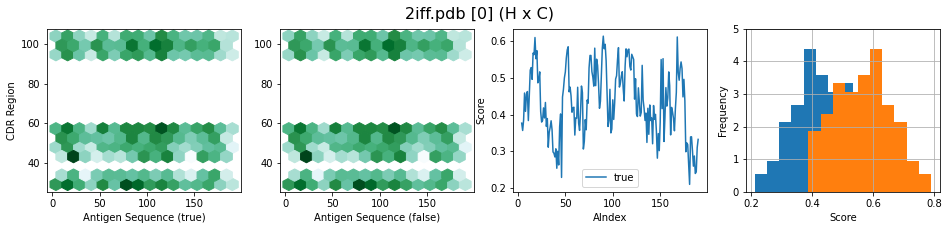

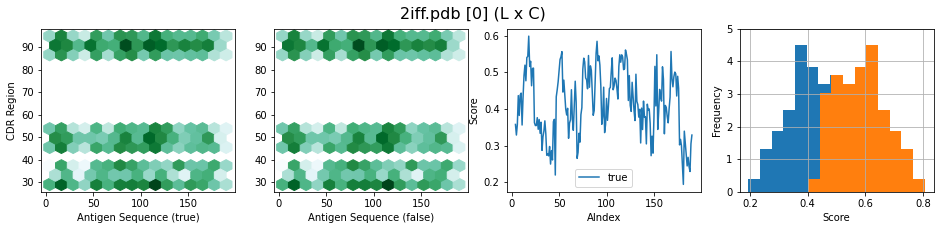

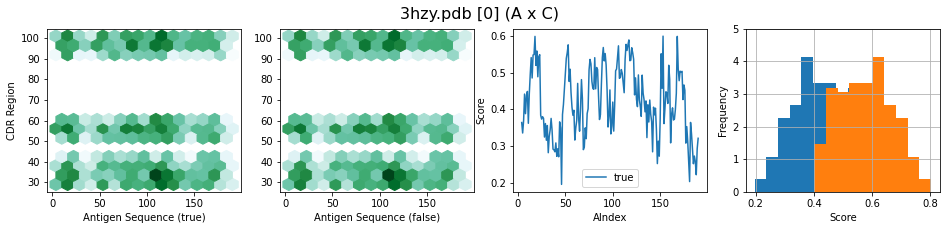

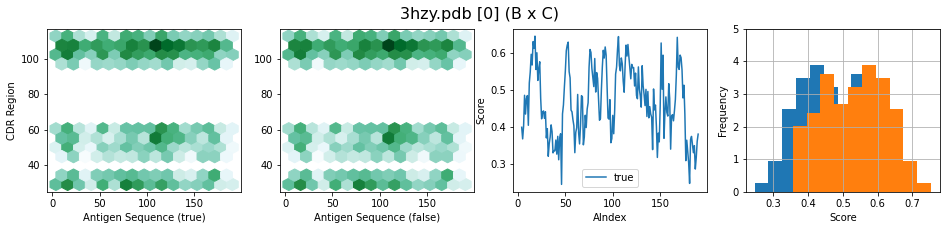

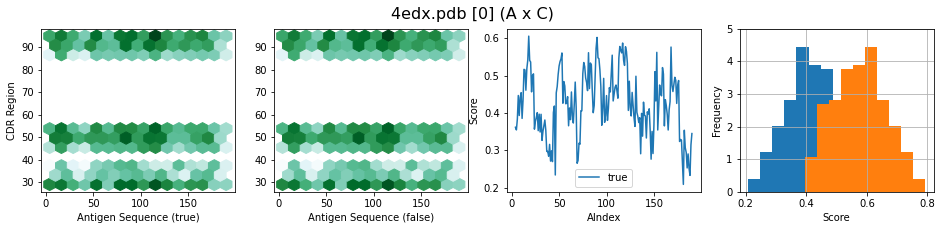

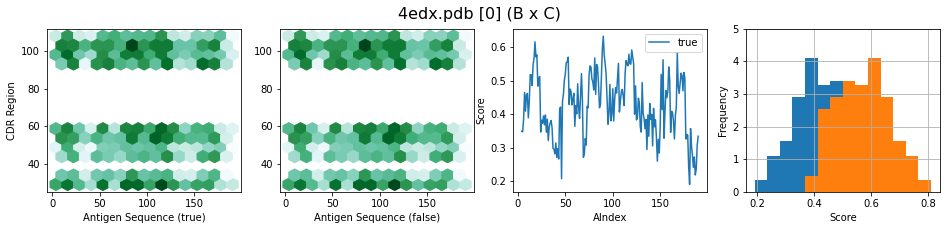

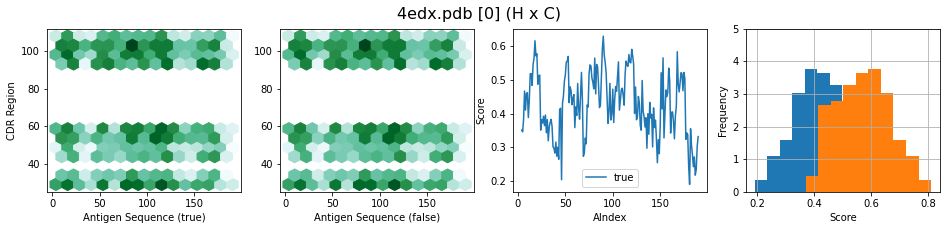

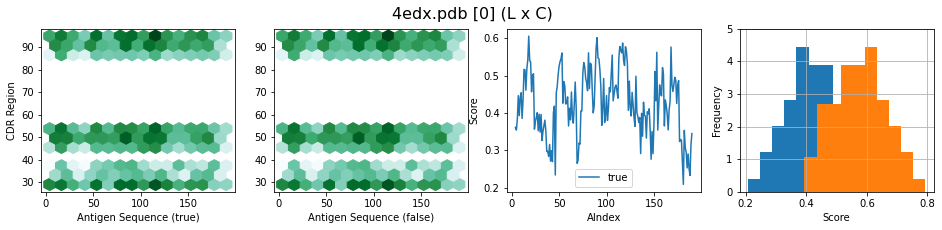

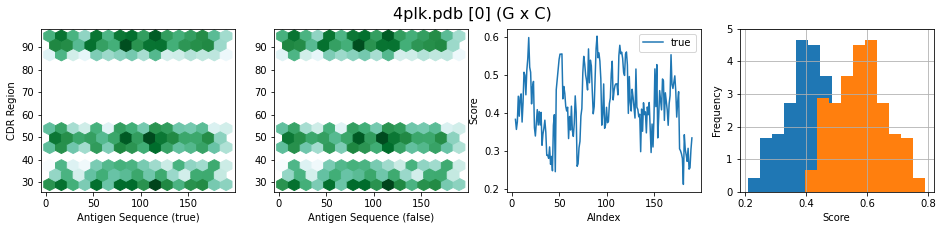

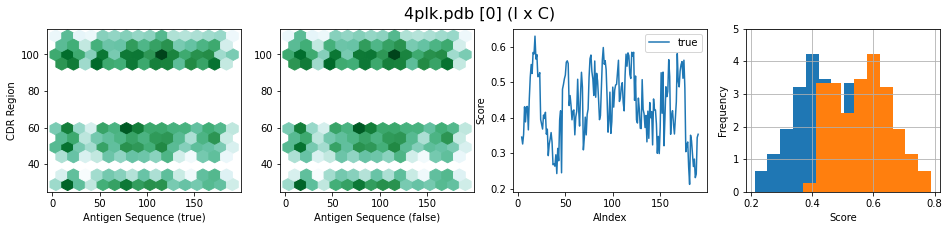

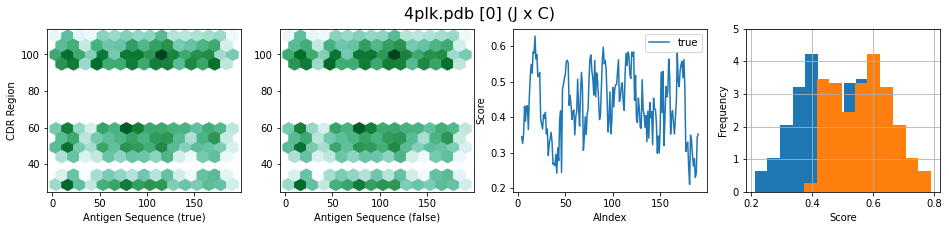

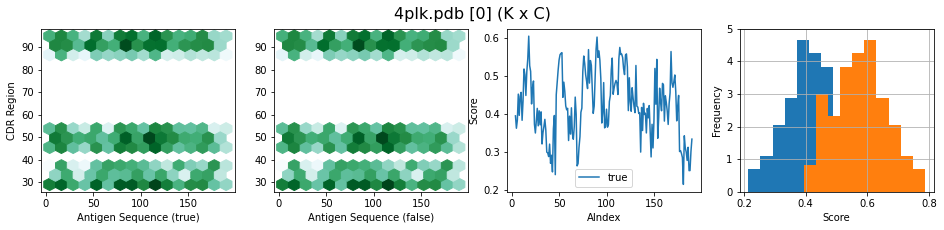

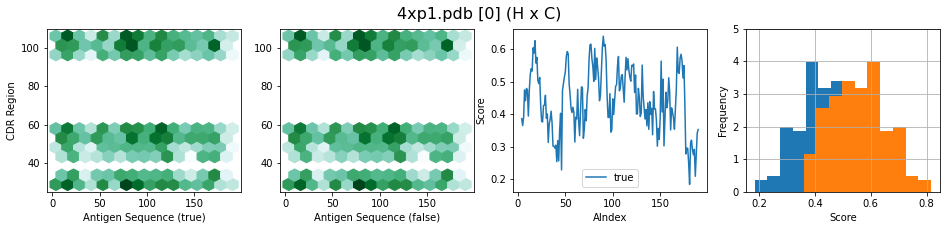

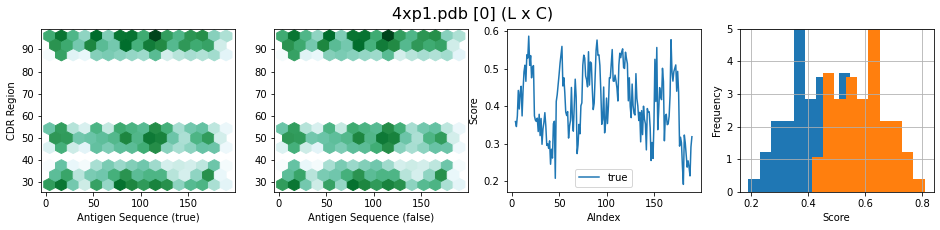

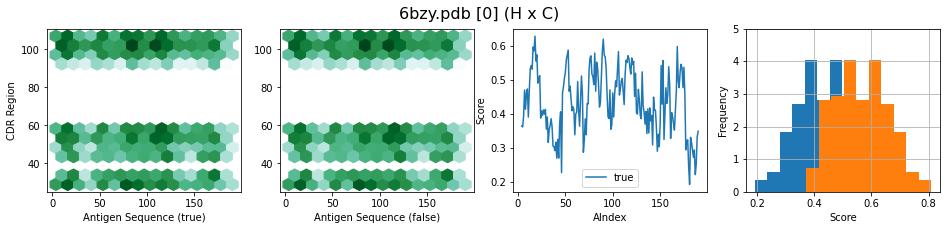

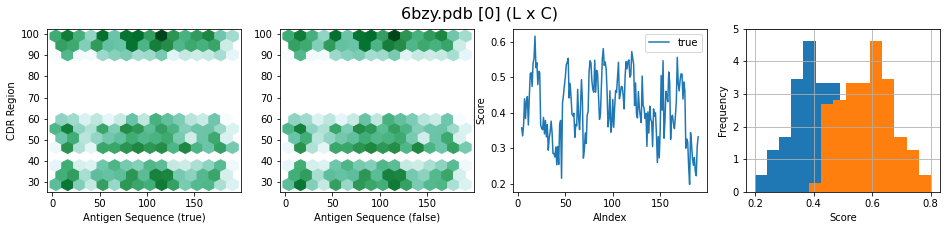

score
file     model akey          
3hzy.pdb 0     C     0.224129
4plk.pdb 0     C     0.202029
4xp1.pdb 0     C     0.200438
4edx.pdb 0     C     0.200166
6bzy.pdb 0     C     0.199298
2iff.pdb 0     C     0.196859

file  model bkey akey     score
3   3hzy.pdb      0    B    C  0.253344
12  4xp1.pdb      0    H    C  0.213820
14  6bzy.pdb      0    H    C  0.207938
9   4plk.pdb      0    I    C  0.207789
10  4plk.pdb      0    J    C  0.206899
0   2iff.pdb      0    H    C  0.205524
5   4edx.pdb      0    B    C  0.200978
6   4edx.pdb      0    H    C  0.200702
4   4edx.pdb      0    A    C  0.199493
7   4edx.pdb      0    L    C  0.199492
11  4plk.pdb      0    K    C  0.198040
8   4plk.pdb      0    G    C  0.195390
2   3hzy.pdb      0    A    C  0.194915
15  6bzy.pdb      0    L    C  0.190658
1   2iff.pdb      0    L    C  0.188194
13  4xp1.pdb      0    L    C  0.187055

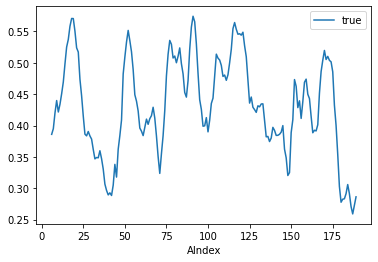

In [0]:
#@title Target evaluation

X_case = encode_features(df_case)
y_case = model.predict(X_case)

clear_output()

data = []
for (file, mid, bk, ak), dfc in df_case.groupby(['File', 'Model', 'BKey', 'AKey']):
  dfc = dfc.copy()

  y_rel = y_case[dfc.index]
  dfc['false'] = y_rel.T[0]
  dfc['true'] = y_rel.T[1]

  df_case.loc[dfc.index, 'false'] = dfc.false
  df_case.loc[dfc.index, 'true'] = dfc.true

  fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(16, 3))

  fig.suptitle(f'{file} [{mid}] ({bk} x {ak})', fontsize=16)
  
  hex_gridsize = 15

  # ax.set_title(title)
  ax.set_xlabel('Antigen Sequence (true)')
  ax.set_ylabel('CDR Region')
  ax.hexbin(dfc.AIndex, dfc.BIndex, -dfc.true, gridsize=hex_gridsize, cmap=plt.cm.BuGn_r)
  # ax.scatter(dfc.AIndex, dfc.BIndex, c=[(.3, .1, 0, a**2) for a in y_rel.T[1]])

  # bx.set_title(title)
  bx.set_xlabel('Antigen Sequence (false)')
  # bx.set_ylabel('CDR Region')
  bx.hexbin(dfc.AIndex, dfc.BIndex, dfc.false, gridsize=hex_gridsize, cmap=plt.cm.BuGn_r)
  # bx.scatter(dfc.AIndex, dfc.BIndex, c=[(0, .1, .3, a**2) for a in y_rel.T[1]])

  dfg = dfc.groupby('AIndex').mean().sort_index()

  cx.set_xlabel('Antigen Sequence')
  cx.set_ylabel('Score')
  dfg[['true']].plot(ax=cx)

  dx.set_xlabel('Score')
  dx.set_ylabel('Frequency')
  dx.set_ylim(0, 5)
  dfg.true.hist(ax=dx, bins=10, density=True)
  dfg.false.hist(ax=dx, bins=10, density=True)

  plt.show()

  data.append(dict(
      file=file,
      model=mid,
      bkey=bk,
      akey=ak,
      # true=dfc.true.mean(),
      # false=dfc.false.mean(),
      # total=(dfc.true - dfc.false).mean(),
      # score=((dfc.true - dfc.false) ** 2).mean(),
      score=(dfc.true ** 2).mean(),
  ))

df_scores = pd.DataFrame(data)
display(df_scores.groupby(['file', 'model', 'akey']).mean().sort_values('score', ascending=False))
display(df_scores.sort_values('score', ascending=False))

# df_scores.sort_values('total', ascending=False).total.reset_index(drop=True).plot()
# plt.show()

df_case.groupby('AIndex').mean().sort_index()[['true']].rolling(contact_buffer, center=True).mean().plot()
plt.show()

In [0]:
#@title Six-way decoy encoding

def encode_sixway_decoy(df, n_samples):
  df_Region = df.Type + df.CDR.astype(str)
  adf_cdr = [df[df_Region == r] for r in cdr_regions]

  assert all(len(a) for a in adf_cdr)
  
  return np.unique(np.concatenate([
      encode_features(c.sample(n_samples, replace=True)).T[6:]
      if len(c) else np.zeros((530 - 6, n_samples))
      for c in adf_cdr
  ]), axis=1).T

In [0]:
#@title Six-way feature encoding

def encode_sixway(df, max_per_file):
  df_Region = df.Type + df.CDR.astype(str)
  adf_cdr = [df[df_Region == r] for r in cdr_regions]

  assert all(len(a) for a in adf_cdr)

  data = []
  for file in set(df.File):

    adf_rel = [c[c.File == file] for c in adf_cdr]

    # if sum(len(a) for a in adf_rel) < 1:
    #   continue

    assert any(len(a) for a in adf_rel)

    data.append(np.unique(np.concatenate([
        encode_features(c.sample(max_per_file, replace=True), verbose=False).T[6:]
        if len(c) else np.zeros((530 - 6, max_per_file))
        for c in adf_rel
    ]), axis=1).T)

  return np.concatenate(data)

In [0]:
#@title Six-way data preparation

def rebuild_sixway(df, max_per_true, decoy_multiple):

  X_true = encode_sixway(df, max_per_true)
  X_false = encode_sixway_decoy(df, int(X_true.shape[0] * decoy_multiple))

  y_true = np.tile([0, 1], (len(X_true), 1))
  y_false = np.tile([1, 0], (len(X_false), 1))

  # clear_output()
  print(X_true.shape, y_true.shape)
  print(X_false.shape, y_false.shape)

  X = np.concatenate([X_true, X_false])
  y = np.concatenate([y_true, y_false])

  sort = np.random.choice(len(X), len(X), replace=False)
  return X[sort], y[sort]

In [0]:
reset_data = True

In [0]:
#@title Six-way classifier model

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation, concatenate
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def foldfn(layers):
  result = None
  for layer in layers:
    result = layer(result) if result is not None else layer
  return result

input_layers = [Input(shape=(530 - 6,)) for cdr in cdr_regions]

input_channels = [Sequential([
    input_layer,
    Dense(10, activation='linear', activity_regularizer=l1(0.002)),
    Activation('relu'),
    Dropout(.5),
	  Dense(4, activation='relu'),
]) for input_layer in input_layers]

output_layer = foldfn([
    concatenate([channel.input for channel in input_channels]),
    Dense(2, activation='linear', activity_regularizer=l1(0.003)),
	  Activation('relu'),
    Dropout(.5),
    Dense(2, activation='linear'),
])

model = Model(inputs=input_layers, outputs=output_layer)

model_metrics = [Precision(class_id=1), Recall(class_id=1)]
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=model_metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 524)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 524)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 524)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 524)]        0                                            
______________________________________________________________________________________________

In [0]:
#@title Progress monitoring

%reload_ext tensorboard
%tensorboard --logdir logs

In [0]:
#@title Six-way training

from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import gc

!rm -rf ./logs

# import multiprocessing
# from imblearn.over_sampling import SMOTE
# n_cores = multiprocessing.cpu_count()
# sm = SMOTE(n_jobs=n_cores)

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
)
tensorboard_callback = TensorBoard('logs', histogram_freq=1)

data_interval = 300

current_epoch = 0

while True:
  if reset_data:
    # if 'X_train' in locals():
    #   del X_train, y_train
    #   del X_test, y_test
    gc.collect()

    print('Rebuilding train data')
    X_train, y_train = rebuild_sixway(df_train, 20, 2)

    print('Rebuilding test data')
    X_test, y_test = rebuild_sixway(df_test, 20, 2)

    # print('SMOTE train data')
    # X_train, y_train = sm.fit_resample(X_train, y_train)
    # print('SMOTE test data')
    # X_test, y_test = sm.fit_resample(X_test, y_test)

    # del df_train_decoy, df_test_decoy
    
    print(X_train.shape)
    print(X_test.shape)
    
    X_train_split = np.hsplit(X_train, 6)
    X_test_split = np.hsplit(X_test, 6)

    del X_train
    del X_test

  reset_data = False
  gc.collect()
  history = model.fit(
      X_train_split,
      y_train,
      validation_data=(X_test_split, y_test),
      start_epoch=current_epoch,
      epochs=current_epoch + data_interval,
      batch_size=2**12,
      callbacks=[lr_callback, tensorboard_callback],
  )
  current_epoch += data_interval
  reset_data = True
  
  gc.collect()

  for metric in [*model_metrics, 'loss']:
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

  y_pred = model.predict(X_test_split).argmax(axis=1)

  y_test_max = y_test.argmax(axis=1)

  print()
  print(classification_report(y_test_max, y_pred, target_names=['False', 'True']))

  M = confusion_matrix(y_test_max, y_pred, normalize='true')

  fig = plt.figure(figsize=(4, 4))
  sns.heatmap(M, annot=True, cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('Ground Truth')
  plt.xlabel('Predicted')
  plt.show()

In [0]:
#@title XGBoost classifier

# from xgboost import XGBClassifier
# import gc

# model = XGBClassifier(
#     verbose_eval=True,
#     learning_rate=0.01,
#     max_depth=6,
# )

# gc.collect()
# model.fit(
#     np.hstack(X_train),
#     np.argmax(y_train, axis=1),
#     eval_set=[(np.hstack(X_test), np.argmax(y_test, axis=1))],
#     eval_metric='mse',
#     early_stopping_rounds=10,
# )

# print(model.score(np.hstack(X_test), np.argmax(y_test, axis=1)))

In [0]:
#@title RAPIDS setup

# !pip install -q cudf-cuda100

# !cp /usr/local/lib/python3.6/dist-packages/librmm.so .

# os.environ['NUMBAPRO_NVVM']='/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so'  
# os.environ['NUMBAPRO_LIBDEVICE']='/usr/local/cuda-10.0/nvvm/libdevice'

# !apt install -q libopenblas-base libomp-dev
# !pip install -q cuml-cuda100

# !cp /usr/local/lib/python3.6/dist-packages/libcuml.so /usr/lib64-nvidia/

# # clear_output()

In [0]:
#@title SVM classifier

# from cuml.svm import SVC



In [0]:
from sklearn.svm import SVC

model = SVC()

In [0]:
X_train, y_train = rebuild_sixway(df_train, 20, 2)
X_test, y_test = rebuild_sixway(df_test, 20, 2)
clear_output()
print(X_train.shape, X_test.shape)

(46806, 3144) (19836, 3144)


In [0]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import gc

# model.fit(X_train, y_train.argmax(axis=1))

# y_test = model.predict(X_test)